In [1]:
from brian2 import *
%matplotlib inline
import numpy as np
from numpy import heaviside
from math import *
import pandas as pd
from numba import jit
from matplotlib import cm
@jit
# Potential function
def U(phi,I=1.01,gamma=1,T=4.615120516841259, tau=1):
    value = (I/gamma)*(1-np.exp(-gamma*T*phi/tau))
    return value
@jit
# Function to convert potential to 'phase' corresponding to Mirollo-Strogatz model
def U_inv(y,I=1.01,gamma=1,T=4.615120516841259,tau=1):
    value = (tau/(gamma*T))*np.log((1-(gamma*y/I))**(-1))
    return value
## Loading Inhibitory and Excitatory Edge topology from a 81 × 81 Matrix specifying 20 connections for each neuron 
# Import Sudoku matrices: (rows: pre-synaptic, columns: post-synaptic)

inhib_connect = np.loadtxt('Clueless_Sudoku_inhib.txt', dtype=int)
excit_connect = np.loadtxt('Clueless_Sudoku_excit.txt', dtype=int)

# Get tuples of corresponding connection indices for putting in Brian2's synapse connect() function
inhib_pre, inhib_post = inhib_connect.nonzero()
excit_pre, excit_post = excit_connect.nonzero()

In [2]:
start_scope()
N = 81                          # No. of neurons
tau = 10*ms                     # Time constant of neuron
#A_osc = 0.2                     # Oscillation amplitude #?
freq = 25*Hz                    # Frequency of common oscillatory drive #?
transm_delay = pow(10,-5)*ms    # Delay between firing and reception of pulse by post-synaptic neuron
Ib_low = 0.58                   # Lower limit of bias current
Ib_upp = 0.64                   # Upper limit of bias current
Ib_val = [Ib_low + (Ib_upp-Ib_low)*( i/9.0 ) for i in range(9)]
order_Ib = np.array([9,1,7,5,2,3,4,6,8]) 
#Ib_array = np.zeros(N,dtype=float)


# Pulse strengths: inhibitory and excitatory
C_inh = -2.7*pow(10,-1)
C_exc = +2.8*pow(10,-6)

eqs = '''
dv/dt = (I+Ib-v)/tau : 1
phase = (freq*t) % 1.0 : 1
I = 30 : 1
Ib : 1
'''
# Create a neuron group 'G' following the above equation
G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='euler')
G.v = 'rand()' #?
G.Ib=0

# Inhibitory synapses
S_inhib = Synapses(G,G, on_pre='v_post += C_inh', delay=transm_delay)
S_inhib.connect(i=inhib_pre, j=inhib_post)

# Excitatory synapses
S_excit = Synapses(G,G, on_pre='v_post += C_exc', delay=transm_delay)
S_excit.connect(i=excit_pre, j=excit_post)

P = PoissonInput(G, 'v', 1,15*Hz, weight=10)

# Record of potential for all neurons
potential = StateMonitor(G, 'v', record=True)

# Record of all spikesfiring_time.t/ms
firing_time = SpikeMonitor(G, variables='phase')
t=10000
run(t*ms)
I = (str(list(G.I.__dict__.values())[1]))[86:88]
# Raster plot of firing
# Plot firing from 'index1' no. of iterations before end

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


In [3]:
runnum=1

In [4]:
import os
script_dir = os.path.dirname('PoissonInput and DC Drive.ipynb')
results_dir = os.path.join(script_dir, '15HzDCw 10mV PI_Results/')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

savefig(results_dir +str(runnum)+'intial')

<Figure size 432x288 with 0 Axes>

In [5]:
SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

csfont = {'fontname':'sans-serif'}
hfont = {'fontname':'serif'}
rcParams.update({'font.family':'serif'})
rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)

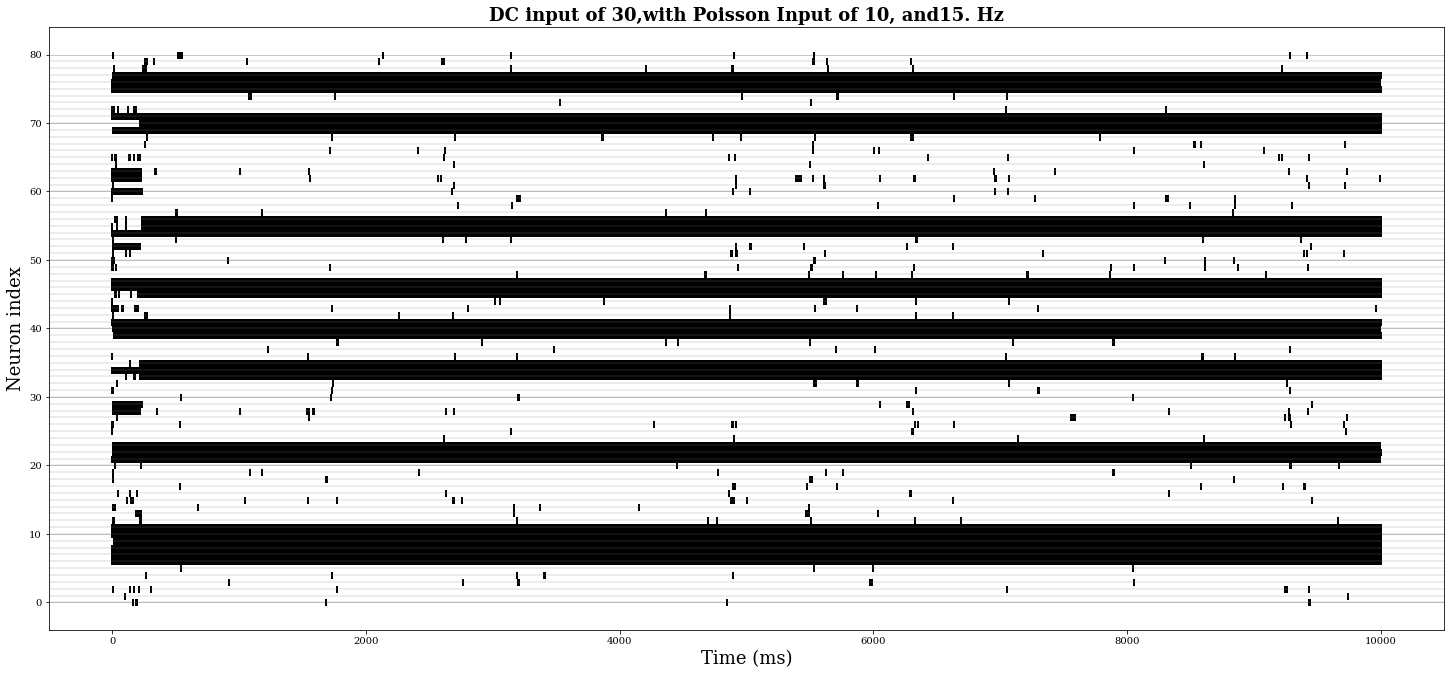

In [6]:
fig = figure(figsize=(25,15))
#x_lim = (3950,3990)

gs = fig.add_gridspec(4,1)
ax=fig.add_subplot(gs[1:,:])
ax.plot(firing_time.t/ms, firing_time.i,'|k', markerfacecolor='xkcd:salmon', mew=2,markersize=7)
#ax.set_xlim(x_lim)
ax.grid(True, 'both','y',linewidth=0.7)
for i in range(80):
    ax.axhline(y=i, linewidth=0.3, color='gray')
csfont = {'fontname':'sans-serif'}
hfont = {'fontname':'serif'}
plt.rc('xtick', labelsize=10)
xlabel('Time (ms)',**hfont,fontsize=18)
ylabel('Neuron index',**hfont,fontsize=18)
title('DC input of '+str(I) +',with Poisson Input of '+ str(P.weight)+', and'+str(P.rate), fontsize=18,**hfont,fontweight="bold")

plt.savefig(results_dir +str(runnum)+ 'Full Raster plot.png',dpi=120)
show()


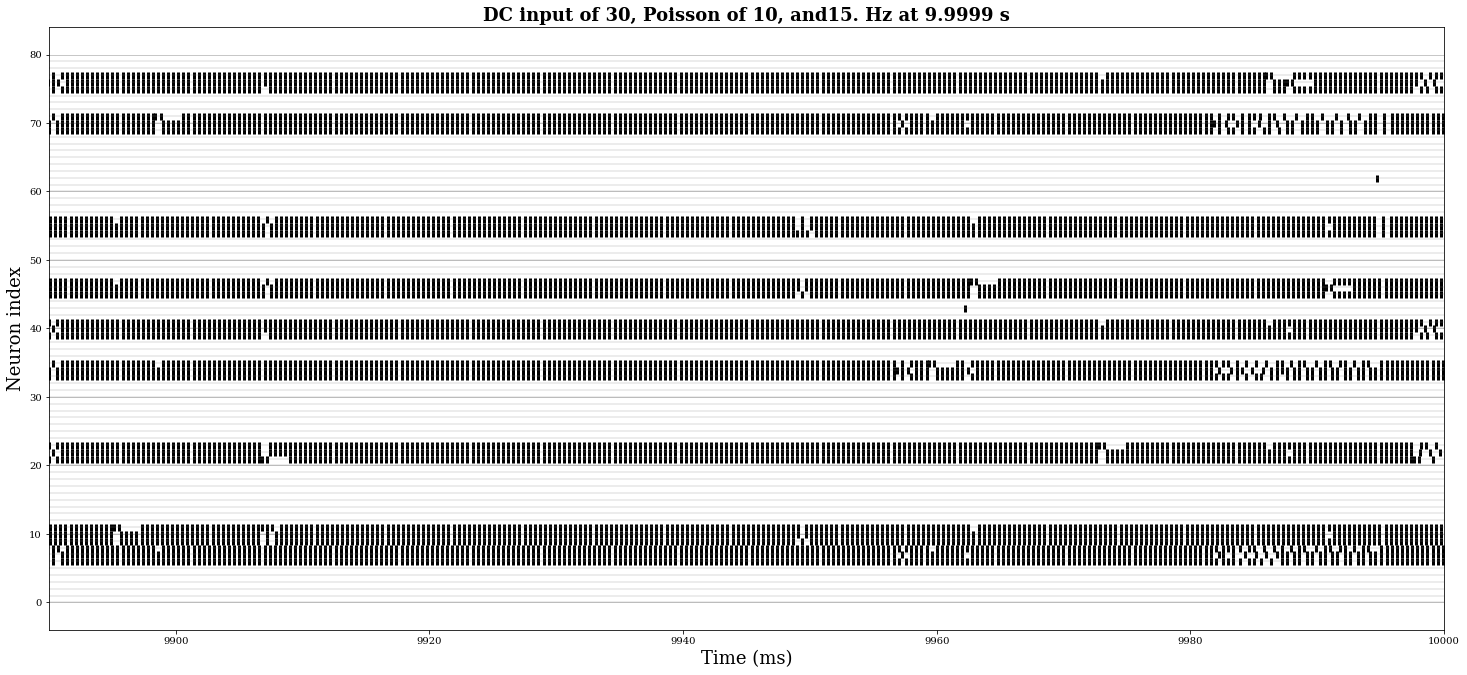

In [7]:
fig = figure(figsize=(25,15))

gs = fig.add_gridspec(4,1)
ax=fig.add_subplot(gs[1:,:])
ax.plot(firing_time.t/ms, firing_time.i,'|k', markerfacecolor='xkcd:salmon', mew=3,markersize=7)
#ax.set_xlim(x_lim)
ax.grid(True, 'both','y',linewidth=0.7)
for i in range(80):
    ax.axhline(y=i, linewidth=0.3, color='gray')
csfont = {'fontname':'sans-serif'}
hfont = {'fontname':'serif'}
plt.rc('xtick', labelsize=10)
x_lim = (9890,10000)
ax.set_xlim(x_lim)
xlabel('Time (ms)',**hfont,fontsize=18)
ylabel('Neuron index',**hfont,fontsize=18)
title('DC input of '+str(I) +', Poisson of '+ str(P.weight)+', and'+str(P.rate)+' at '+str(potential.t[-1]), fontsize=18,**hfont,fontweight="bold")

plt.savefig(results_dir +str(runnum)+ 'End_Raster_plot.png',dpi=120)
show()

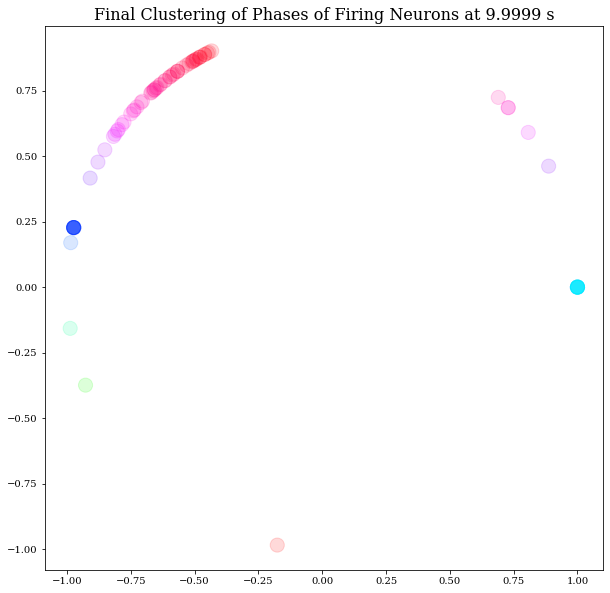

60


In [8]:
pot_arr = potential.v.copy()
pot_arr[pot_arr>1] = 1
phase = U_inv(pot_arr)
index2 = -1
sorted_phase = np.sort(phase[:,index2])

index3 = -1

sin_phase = np.sin(2*pi*phase[:,index3])
cos_phase = np.cos(2*pi*phase[:,index3])
colors=sin_phase
figure(figsize=(10,10))
scatter(cos_phase,sin_phase,c=colors, s=200, cmap='hsv', alpha=0.15)

# xlim((-1.1,1.1))
#ylim((-1.1,1.1))
plt.title('Final Clustering of Phases of Firing Neurons at ' + str(potential.t[index3]), fontsize=16)
plt.savefig(results_dir +str(runnum)+ 'Final Clustering.png',dpi=120)
show()
print(len(np.unique(sin_phase)))

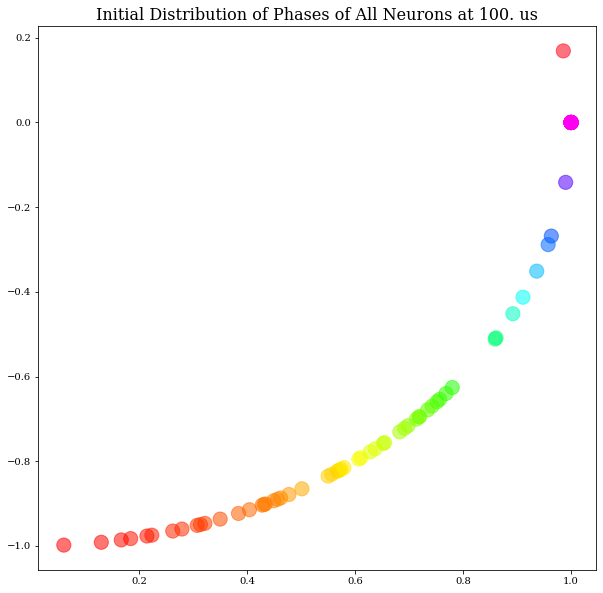

58


In [9]:
#Initial Distribution of Phases

index3 = 1
sin_phase = np.sin(2*pi*phase[:,index3])
cos_phase = np.cos(2*pi*phase[:,index3])
colors=sin_phase
figure(figsize=(10,10))
scatter(cos_phase,sin_phase,c=colors, s=200, cmap='hsv', alpha=0.55)

# xlim((-1.1,1.1))
#ylim((-1.1,1.1))
plt.title('Initial Distribution of Phases of All Neurons at ' + str(potential.t[index3]), fontsize=16)
plt.savefig(results_dir +str(runnum)+ 'Initial Distribution of Phases.png',dpi=120)
show()
print(len(np.unique(sin_phase)))

In [10]:
print('Total Phases Of all Neurons At the End '+str(len(np.unique(sin_phase))))
print('Time step ' + str(defaultclock.dt))
print('Run Time ' +str(len(potential.t/ms))+' ms')
print('DC Input of '+str(I))
print('Poisson Input at '+ str(P.weight)+' of Frequency '+str(P.rate))
print('Firing Rate Per Neuron across Simulation Run '+ str(int(len(firing_time.t/ms))/(81*25000)))

Total Phases Of all Neurons At the End 58
Time step 100. us
Run Time 100000 ms
DC Input of 30
Poisson Input at 10 of Frequency 15. Hz
Firing Rate Per Neuron across Simulation Run 0.3116064197530864


No handles with labels found to put in legend.


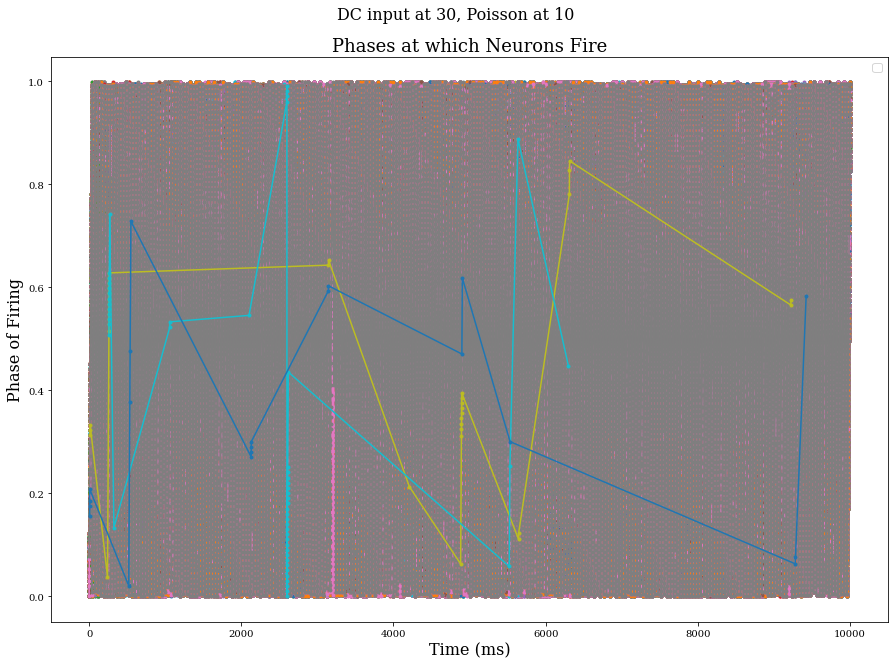

In [11]:
# Plot the phase at the time of firing of a neuron
# Plot this for all neurons together in one graph
fig=figure(figsize=(15,10))
tight_layout()
ax.grid(True, 'both','y',linewidth=0.7)
subplots_adjust(top=0.91)
title('Phases at which Neurons Fire', fontsize=18)
suptitle('DC input at '+str(I) +', Poisson at '+ str(P.weight),**hfont,fontsize=16)
for i in range(N):
    plot(firing_time.values('t')[i]/ms, firing_time.values('phase')[i], '.-')

plt.rc('xtick', labelsize=10)  
ylim=(0.15,0.45)
#xlim(24000,25000)

xlabel('Time (ms)',**hfont,fontsize=16)
ylabel('Phase of Firing',**hfont,fontsize=16)
legend(loc='upper right', fontsize='large')
savefig(results_dir +str(runnum)+ 'Directed Throughout Phases of Firing.png',dpi=120)
show()

No handles with labels found to put in legend.


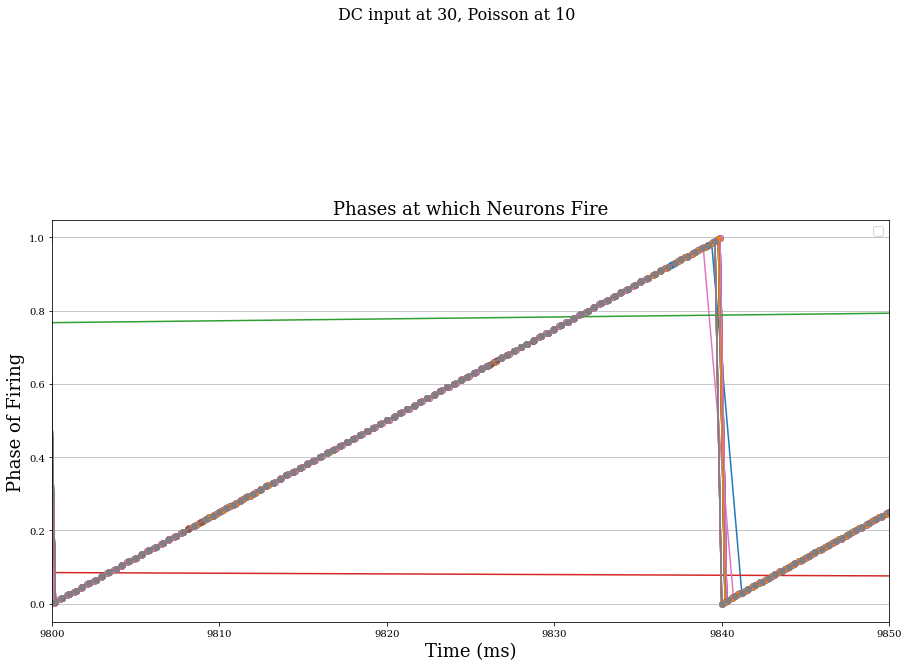

In [18]:
# Plot the final phases of firing of neurons at the end of the simulation
fig = figure(figsize=(15,10))

gs = fig.add_gridspec(4,1)
ax=fig.add_subplot(gs[1:,:])
ax.grid(True, 'both','y',linewidth=0.7)

title('Phases at which Neurons Fire', fontsize=18)
suptitle('DC input at '+str(I) +', Poisson at '+ str(P.weight),**hfont,fontsize=16)
for i in range(N):
    ax.plot(firing_time.values('t')[i]/ms, firing_time.values('phase')[i], '.-',mew=3,markersize=7)

plt.rc('xtick', labelsize=10)  
ylim=(0.15,0.45)
ax.set_xlim(9800,9850)
xlabel('Time (ms)',**hfont,fontsize=18)
ylabel('Phase of Firing',**hfont,fontsize=18)
legend(loc='upper right', fontsize='large')
savefig(results_dir +str(runnum)+ 'Directed End Phases of Firing.png',dpi=120)
show()

In [13]:
def get_time_float(st):
#     print(st,type(st))
    st = format(st)
#     print(st,type(st))
    spl = st.split()
    if spl[1] == 'ms':
        return float(spl[0])
    elif spl[1] == 's':
        return float(spl[0])*1000
    else:
        return float(spl[0])/1000000
        return False
    
    
msecond = 1e-3
second = 1

v_values = firing_time.values('t')
indice = []
firing_data = []
# print(v_values.keys())
for i in list(v_values.keys())[:]:
     firing_data += [[get_time_float(x),i] for x in v_values[i]]
#     n_index = i
#print(firing_data)

firing_data_short=np.asarray(firing_data) 
import json

with open(results_dir +'DC_only_firing_data_'+str(I)+'.json','w') as inf:
    json.dump(firing_data,inf)
    
firing_data_short=np.asarray(sorted(firing_data))

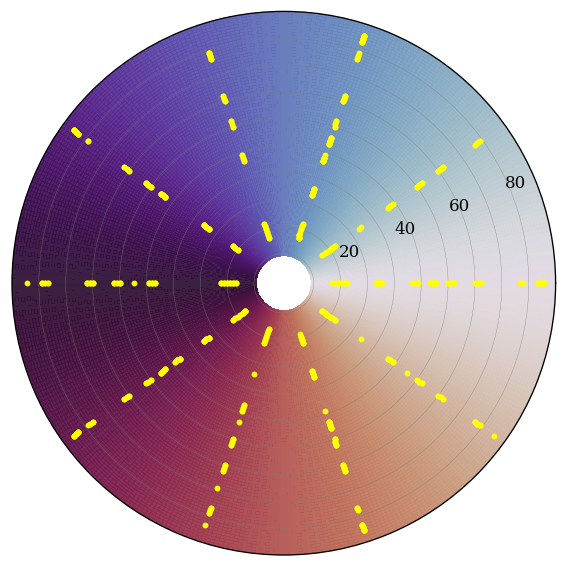

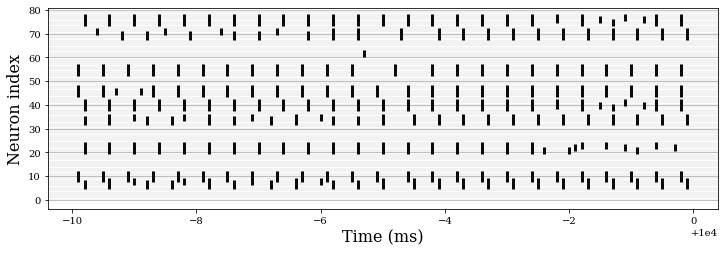

In [14]:
#At the end
low,up = 9990,10000
fir = np.asarray([x for x in firing_data_short if  x[0] > low and x[0] < up])

azimuths = np.arange(0, 361, 1)
zeniths = np.arange(9, 92, 1)
values = azimuths * np.ones((83, 361))
fig, ax = plt.subplots(dpi=120,subplot_kw=dict(projection='polar'), figsize=(6,6))
ax.pcolormesh(azimuths*np.pi/180.0, zeniths, values[:-1,:-1], cmap=plt.get_cmap('twilight'),alpha=0.95)
norm_phase = ((fir[:,0])*2*np.pi)
norm_indices = (fir[:,1])+10


theta = np.arange(0,2*np.pi,0.01)
for i in range(10,91,9):
    ax.plot(theta , i*np.ones_like(theta), ls='-', lw=0.2, color='gray')
    
    

ax.plot(norm_phase, norm_indices, color='#FFFF00', marker='.',mew=2, markersize=3, ls='')
ax.set_xticks([])
# ax.set_yticks(range(10,91,10))
# ax.set_axis_on()
plt.savefig(results_dir +str(runnum)+ 'Final Firing Phase Code.png',dpi=120)
# plt.savefig(results_dir +str(runnum)+ 'Initial Firing Phase Code.png')
plt.show()
from matplotlib import cm

# Plot linear raster plot with colour coding at the bottom
raster = plt.figure(figsize=(12,5))
gs = raster.add_gridspec(4,1)
fire = raster.add_subplot(gs[:3])
fire.plot(fir[:,0], fir[:,1], '|k',mew=3,ms=7)
fire.grid(True, 'both','y',linewidth=0.7)
for i in range(80):
    fire.axhline(y=i, linewidth=0.2, color='gray')
fire.set_yticks(np.arange(0,81,10))
xlabel('Time (ms)', fontsize=16)
ylabel('Neuron index', fontsize=16)
plt.savefig(results_dir +str(runnum)+ 'Rastor_Colored_Final.png')
plt.show()

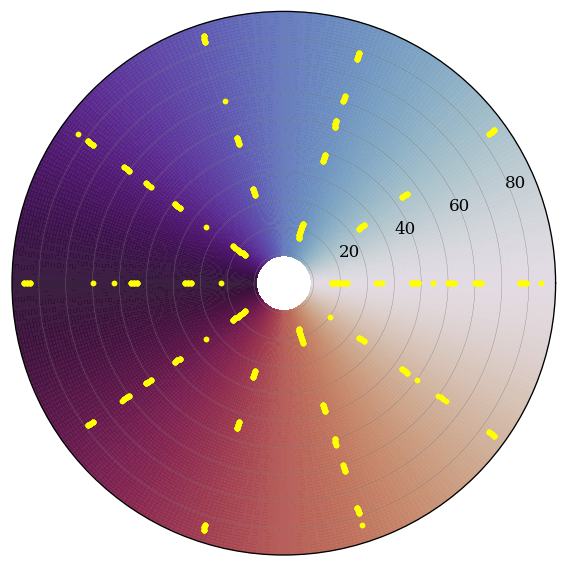

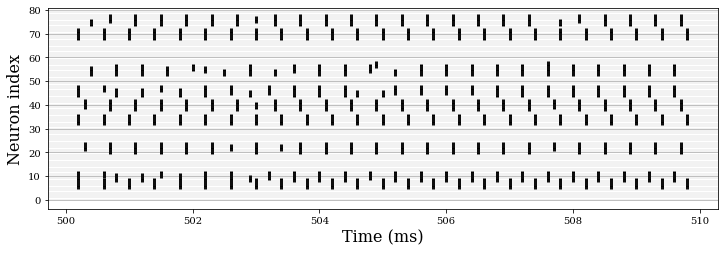

In [15]:
#In the Middle 
low,up = 500,510
k=(low,up)
fir = np.asarray([x for x in firing_data_short if  x[0] > low and x[0] < up])
azimuths = np.arange(0, 361, 1)
zeniths = np.arange(9, 92, 1)
values = azimuths * np.ones((83, 361))
fig, ax = plt.subplots(dpi=120,subplot_kw=dict(projection='polar'), figsize=(6,6))
ax.pcolormesh(azimuths*np.pi/180.0, zeniths, values[:-1,:-1], cmap=plt.get_cmap('twilight'),alpha=0.95)
norm_phase = ((fir[:,0])*2*np.pi)
norm_indices = (fir[:,1])+10

theta = np.arange(0,2*np.pi,0.01)
for i in range(10,91,9):
    ax.plot(theta , i*np.ones_like(theta), ls='-', lw=0.2, color='gray')
    
    

ax.plot(norm_phase, norm_indices, color='#FFFF00', marker='.',mew=2, markersize=3, ls='')
ax.set_xticks([])
# plt.savefig(results_dir +str(runnum)+ 'Final Firing Phase Code.png',dpi=120)
plt.savefig(results_dir +str(runnum)+ 'Mid Firing Phase Code.png',dpi=120)
plt.show()

# Plot linear raster plot with colour coding at the bottom
raster = plt.figure(figsize=(12,5))
gs = raster.add_gridspec(4,1)
xlim = k

fire = raster.add_subplot(gs[:3])
fire.plot(fir[:,0], fir[:,1], '|k',mew=3,ms=7)
fire.grid(True, 'both','y',linewidth=0.7)
for i in range(80):
    fire.axhline(y=i, linewidth=0.2, color='gray')
fire.set_yticks(np.arange(0,81,10))
xlabel('Time (ms)', fontsize=16)
ylabel('Neuron index', fontsize=16)
plt.savefig(results_dir +str(runnum)+ 'Rastor_Colored_Mid.png',dpi=120)
plt.show()

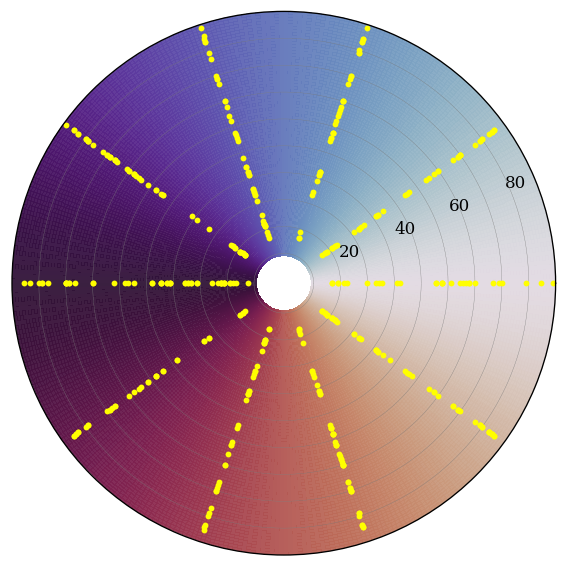

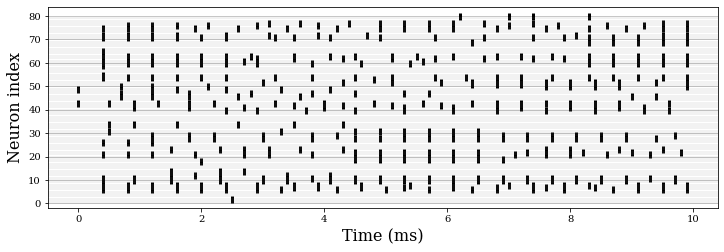

In [16]:
#Initial 
low,up = 0,10
k=(low,up)
fir = np.asarray([x for x in firing_data_short if  x[0] > low and x[0] < up])
azimuths = np.arange(0, 361, 1)
zeniths = np.arange(9, 92, 1)
values = azimuths * np.ones((83, 361))
fig, ax = plt.subplots(dpi=120,subplot_kw=dict(projection='polar'), figsize=(6,6))
ax.pcolormesh(azimuths*np.pi/180.0, zeniths, values[:-1,:-1], cmap=plt.get_cmap('twilight'),alpha=0.95)
norm_phase = ((fir[:,0])*2*np.pi)
norm_indices = (fir[:,1])+10

theta = np.arange(0,2*np.pi,0.01)
for i in range(10,91,9):
    ax.plot(theta , i*np.ones_like(theta), ls='-', lw=0.2, color='gray')
    
    

ax.plot(norm_phase, norm_indices, color='#FFFF00', marker='.',mew=2, markersize=3, ls='')
ax.set_xticks([])
# plt.savefig(results_dir +str(runnum)+ 'Final Firing Phase Code.png',dpi=120)
plt.savefig(results_dir +str(runnum)+ 'Mid Firing Phase Code.png',dpi=120)
plt.show()

# Plot linear raster plot with colour coding at the bottom
raster = plt.figure(figsize=(12,5))
gs = raster.add_gridspec(4,1)
xlim = k

fire = raster.add_subplot(gs[:3])
fire.plot(fir[:,0], fir[:,1], '|k',mew=3,ms=7)
fire.grid(True, 'both','y',linewidth=0.7)
for i in range(80):
    fire.axhline(y=i, linewidth=0.2, color='gray')

fire.set_yticks(np.arange(0,81,10))
xlabel('Time (ms)', fontsize=16)
ylabel('Neuron index', fontsize=16)
plt.savefig(results_dir +str(runnum)+ 'Rastor_Colored_Mid.png',dpi=120)
plt.show()

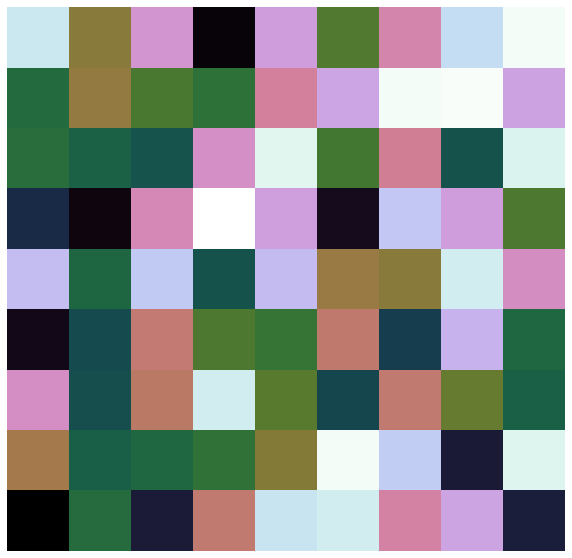

In [71]:
#Random 9 coloring of Sudoku 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

figure(figsize=(10,10))

df = pd.DataFrame(np.random.random((9,9)), columns=["a","b","c","d","e","f","g","h","i"])

# plot using a color palette
mu=sns.heatmap(df, cmap="cubehelix",cbar=False,alpha=1)
mu.set_xticks([])
mu.set_yticks([])
# title('9 Colourings of the 9x9 Sudoku')
savefig(script_dir+str(runnum+10)+'Sudoku.png',dpi=200)
show()